# Test Changing yz extents
Here we test the restart loader libraries

In [1]:
#Need this to add libraries in parent folder
import sys
sys.path.append('..')
sys.path.append('.')
sys.path.append('../lib')

In [2]:
import lib.analysis as anl 
import lib.array_ops as ao
import lib.data_h5 as dh5
import lib.data_netcdf4 as dnc
import lib.fpc as fpc
import lib.frametransform as ft
import lib.metadata as md

import lib.plot.oned as plt1d
import lib.plot.twod as plt2d
import lib.plot.debug as pltdebug
import lib.plot.fourier as pltfr
import lib.plot.resultsmanager as rsltmng
import lib.plot.velspace as pltvv

import os
import math
import numpy as np

### Load and transform fields

In [3]:
# load analysis file
analysisflnm = '../analysisinputsperp/m06_th45inputt2000.txt'
path,resultsdir,vmax,dv,numframe,dx,xlim,ylim,zlim = anl.analysis_input(flnm = analysisflnm)
path_particles = path+'Output/Raw/Sp01/raw_sp01_{:08d}.h5'

In [4]:
#load fields
dfields = dh5.field_loader(path=path,num=numframe)

#load flow data
dflow = dh5.flow_loader(path=path,num=numframe)

In [5]:
all_dfields = dh5.all_dfield_loader(path=path, verbose=False)
vshock, xshockvals = ft.shock_from_ex_cross(all_dfields)

Warning, using dt = 0.01 Omega^-1... TODO: automate loading this...


In [6]:
#loretnz transform fields
dfields = ft.lorentz_transform_vx(dfields,vshock)
_fields = []
for k in range(0,len(all_dfields['dfields'])):
    _fields.append(ft.lorentz_transform_vx(all_dfields['dfields'][k],vshock))
all_dfields['dfields'] = _fields

#tranform flow
dflow = ft.transform_flow(dflow,vshock)

In [7]:
#check that xlim ylim and zlim are not none
#if so, use boundaries of box
cellsizexx = dfields['ex_xx'][1]-dfields['ex_xx'][0]
cellsizeyy = dfields['ex_yy'][1]-dfields['ex_yy'][0]
cellsizezz = dfields['ex_zz'][1]-dfields['ex_zz'][0]

xlim = [dfields['ex_xx'][0]-cellsizexx/2.,dfields['ex_xx'][-1]+cellsizexx/2.]
ylim = [dfields['ex_yy'][0]-cellsizeyy/2.,dfields['ex_yy'][-1]+cellsizeyy/2.]
zlim = [dfields['ex_zz'][0]-cellsizeyy/2.,dfields['ex_zz'][-1]+cellsizeyy/2.]

# load particle data
dparticles = dh5.read_box_of_particles(path_particles, numframe, xlim[0], xlim[1], ylim[0], ylim[1], zlim[0], zlim[1])

In [8]:
ylim

[0.0, 12.0]

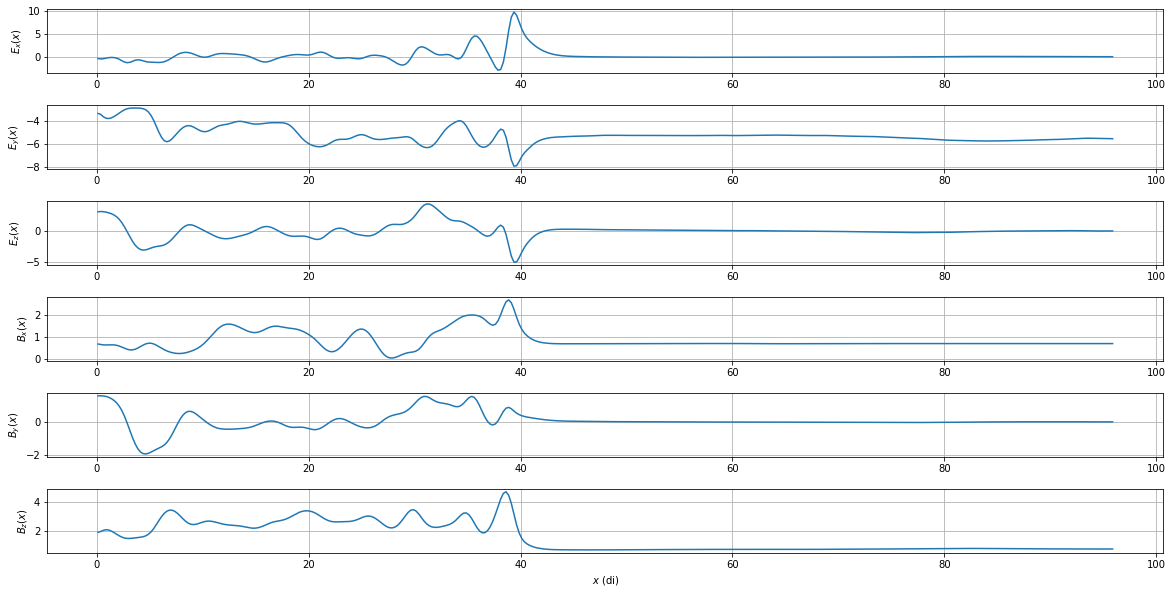

In [9]:
# plot all the lorentz transformed fields
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

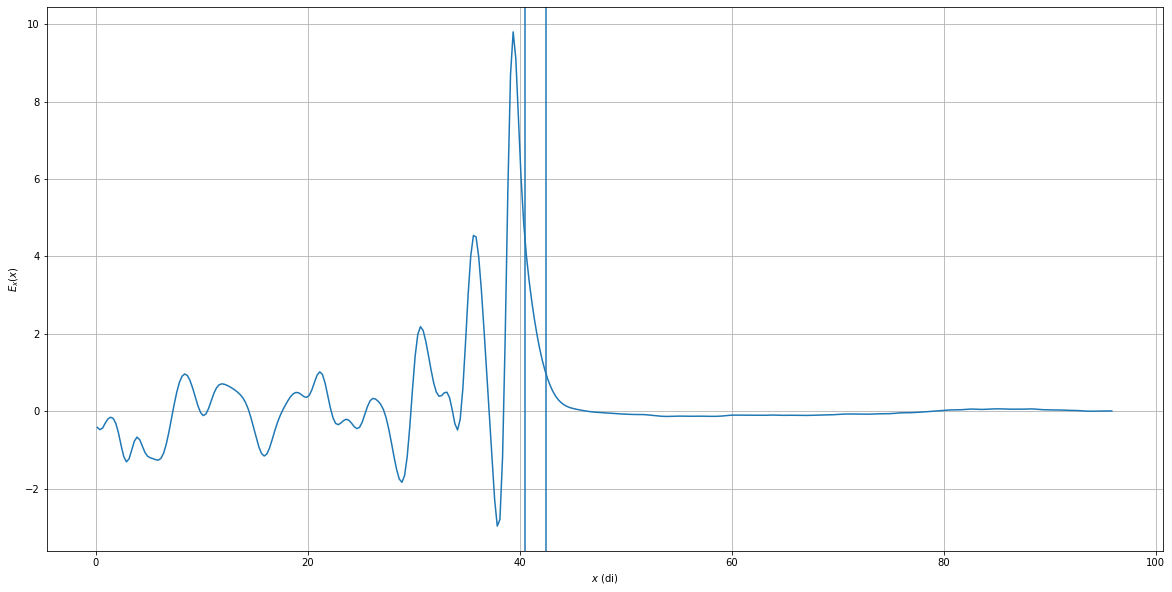

In [12]:
#option one, use Ex(x,y=0,z=0) to find SDA bounds. Should range from the start of the ramp to the first zero crossing
yyindex = 0
zzindex = 0

startval = 40.5
endval = 42.5

plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

#### Do correlation using entire yz box extent

In [13]:
x1 = startval
x2 = endval
y1 = 0.
y2 = 12.
z1 = 0.
z2 = 12.

fieldkey = 'ex'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEx = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, fieldkey, directionkey)

fieldkey = 'ey'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEy = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, fieldkey, directionkey)

fieldkey = 'ez'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEz = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, fieldkey, directionkey)

vx_xy,vy_xz = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
vx_xz,vz_xz = ao.mesh_3d_to_2d(vx,vy,vz,'xz')
vy_yz,vz_yz = ao.mesh_3d_to_2d(vx,vy,vz,'yz')
H_xy = ao.array_3d_to_2d(hist,'xy')
H_xz = ao.array_3d_to_2d(hist,'xz')
H_yz = ao.array_3d_to_2d(hist,'yz')
CEx_xy = ao.array_3d_to_2d(CEx,'xy')
CEx_xz = ao.array_3d_to_2d(CEx,'xz')
CEx_yz = ao.array_3d_to_2d(CEx,'yz')
CEy_xy = ao.array_3d_to_2d(CEy,'xy')
CEy_xz = ao.array_3d_to_2d(CEy,'xz')
CEy_yz = ao.array_3d_to_2d(CEy,'yz')
CEz_xy = ao.array_3d_to_2d(CEz,'xy')
CEz_xz = ao.array_3d_to_2d(CEz,'xz')
CEz_yz = ao.array_3d_to_2d(CEz,'yz')

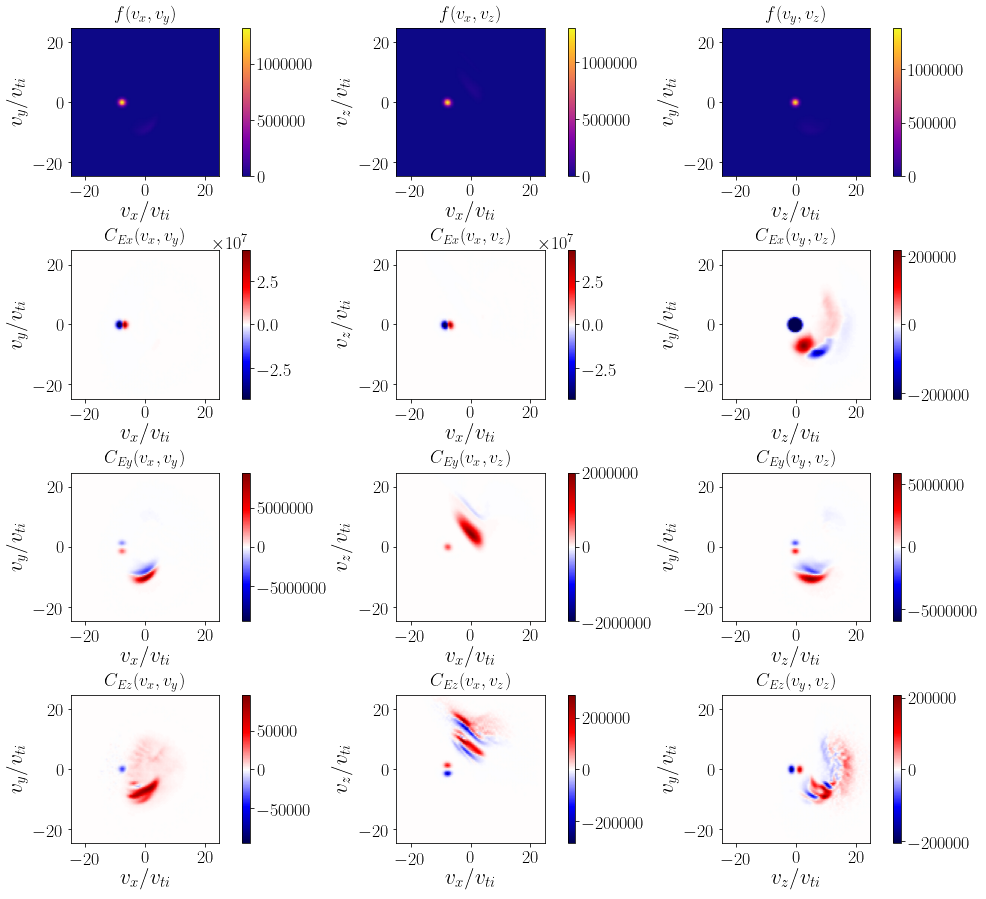

In [15]:
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

#### Do correlation using subset of yz box extent

In [16]:
x1 = startval
x2 = endval
y1 = 0.
y2 = 3.
z1 = 0.
z2 = 3.

fieldkey = 'ex'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEx = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, fieldkey, directionkey)

fieldkey = 'ey'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEy = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, fieldkey, directionkey)

fieldkey = 'ez'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEz = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, fieldkey, directionkey)

vx_xy,vy_xz = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
vx_xz,vz_xz = ao.mesh_3d_to_2d(vx,vy,vz,'xz')
vy_yz,vz_yz = ao.mesh_3d_to_2d(vx,vy,vz,'yz')
H_xy = ao.array_3d_to_2d(hist,'xy')
H_xz = ao.array_3d_to_2d(hist,'xz')
H_yz = ao.array_3d_to_2d(hist,'yz')
CEx_xy = ao.array_3d_to_2d(CEx,'xy')
CEx_xz = ao.array_3d_to_2d(CEx,'xz')
CEx_yz = ao.array_3d_to_2d(CEx,'yz')
CEy_xy = ao.array_3d_to_2d(CEy,'xy')
CEy_xz = ao.array_3d_to_2d(CEy,'xz')
CEy_yz = ao.array_3d_to_2d(CEy,'yz')
CEz_xy = ao.array_3d_to_2d(CEz,'xy')
CEz_xz = ao.array_3d_to_2d(CEz,'xz')
CEz_yz = ao.array_3d_to_2d(CEz,'yz')

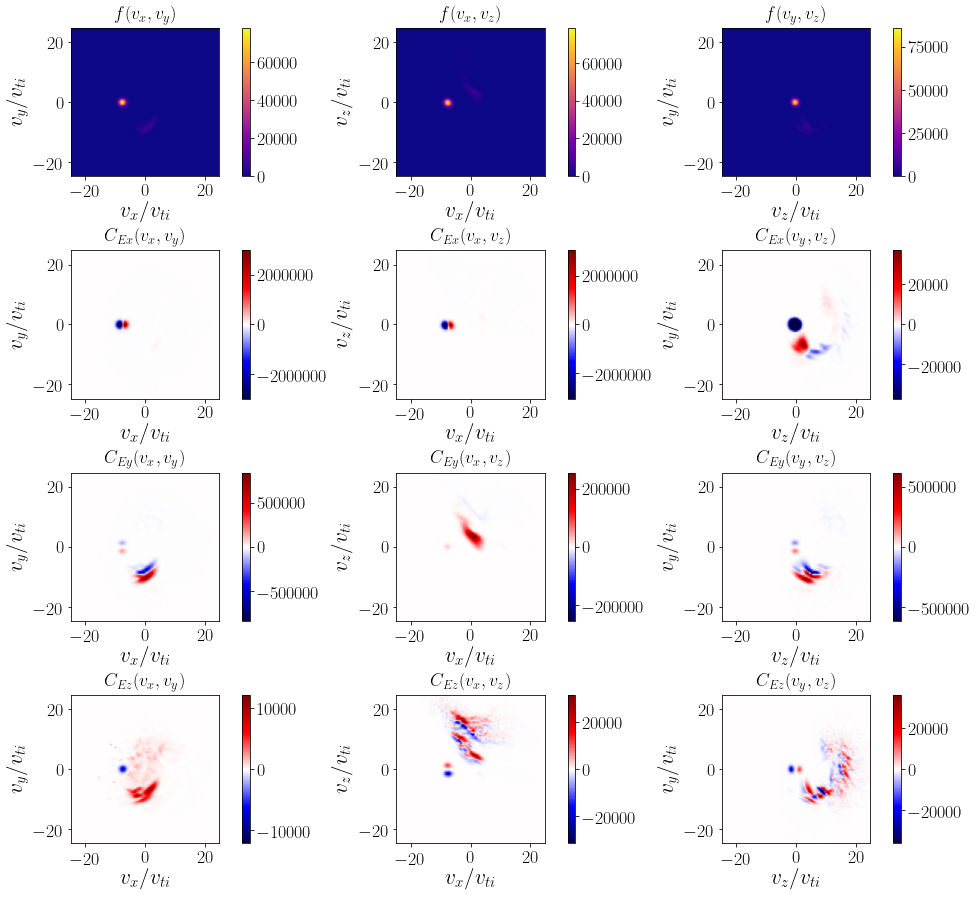

In [17]:
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

#### Do correlation using different subset

In [18]:
x1 = startval
x2 = endval
y1 = 3.
y2 = 6.
z1 = 3.
z2 = 6.

fieldkey = 'ex'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEx = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, fieldkey, directionkey)

fieldkey = 'ey'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEy = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, fieldkey, directionkey)

fieldkey = 'ez'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEz = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, fieldkey, directionkey)

vx_xy,vy_xz = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
vx_xz,vz_xz = ao.mesh_3d_to_2d(vx,vy,vz,'xz')
vy_yz,vz_yz = ao.mesh_3d_to_2d(vx,vy,vz,'yz')
H_xy = ao.array_3d_to_2d(hist,'xy')
H_xz = ao.array_3d_to_2d(hist,'xz')
H_yz = ao.array_3d_to_2d(hist,'yz')
CEx_xy = ao.array_3d_to_2d(CEx,'xy')
CEx_xz = ao.array_3d_to_2d(CEx,'xz')
CEx_yz = ao.array_3d_to_2d(CEx,'yz')
CEy_xy = ao.array_3d_to_2d(CEy,'xy')
CEy_xz = ao.array_3d_to_2d(CEy,'xz')
CEy_yz = ao.array_3d_to_2d(CEy,'yz')
CEz_xy = ao.array_3d_to_2d(CEz,'xy')
CEz_xz = ao.array_3d_to_2d(CEz,'xz')
CEz_yz = ao.array_3d_to_2d(CEz,'yz')

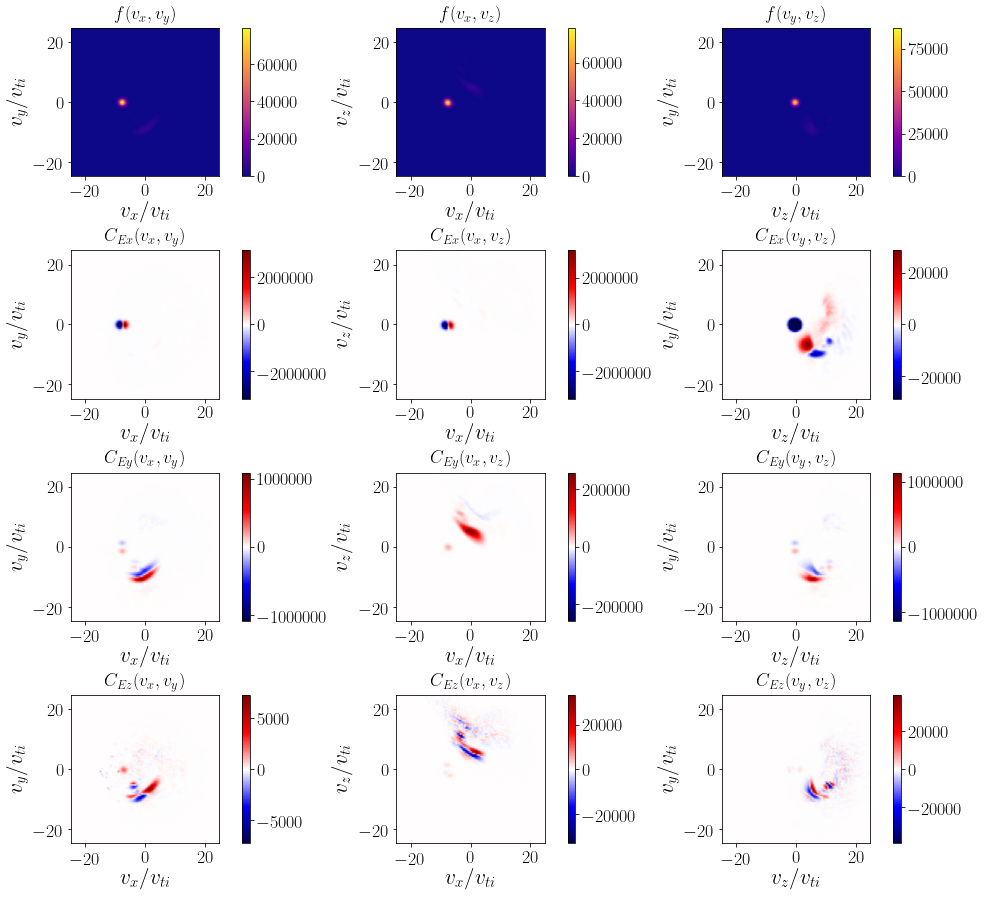

In [19]:
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

### Use delta fields and changing box extents

#### Do correlation using entire yz box extent

In [20]:
dfluc = anl.remove_average_fields_over_yz(dfields)

In [21]:
x1 = startval
x2 = endval
y1 = 0.
y2 = 12.
z1 = 0.
z2 = 12.

fieldkey = 'ex'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEx = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfluc, vshock, fieldkey, directionkey)

fieldkey = 'ey'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEy = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfluc, vshock, fieldkey, directionkey)

fieldkey = 'ez'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEz = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfluc, vshock, fieldkey, directionkey)

vx_xy,vy_xz = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
vx_xz,vz_xz = ao.mesh_3d_to_2d(vx,vy,vz,'xz')
vy_yz,vz_yz = ao.mesh_3d_to_2d(vx,vy,vz,'yz')
H_xy = ao.array_3d_to_2d(hist,'xy')
H_xz = ao.array_3d_to_2d(hist,'xz')
H_yz = ao.array_3d_to_2d(hist,'yz')
CEx_xy = ao.array_3d_to_2d(CEx,'xy')
CEx_xz = ao.array_3d_to_2d(CEx,'xz')
CEx_yz = ao.array_3d_to_2d(CEx,'yz')
CEy_xy = ao.array_3d_to_2d(CEy,'xy')
CEy_xz = ao.array_3d_to_2d(CEy,'xz')
CEy_yz = ao.array_3d_to_2d(CEy,'yz')
CEz_xy = ao.array_3d_to_2d(CEz,'xy')
CEz_xz = ao.array_3d_to_2d(CEz,'xz')
CEz_yz = ao.array_3d_to_2d(CEz,'yz')

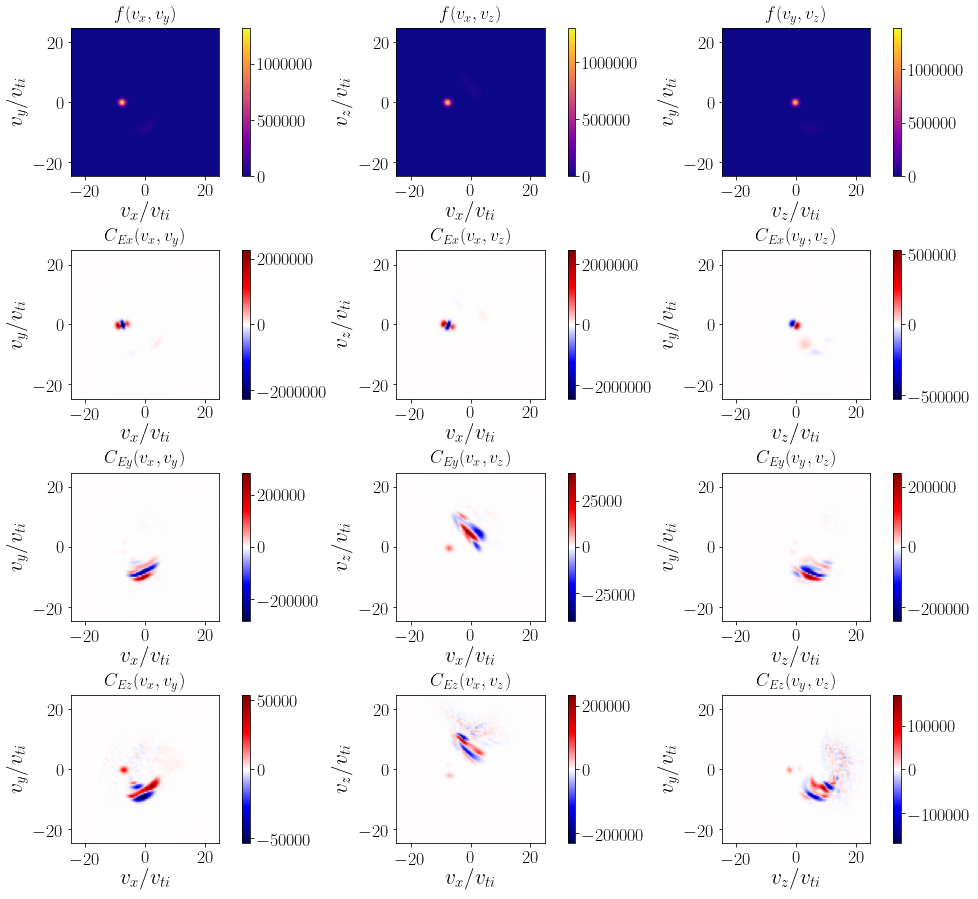

In [22]:
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

### Do correlation using different subset

In [23]:
x1 = startval
x2 = endval
y1 = 3.
y2 = 6.
z1 = 3.
z2 = 6.

fieldkey = 'ex'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEx = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfluc, vshock, fieldkey, directionkey)

fieldkey = 'ey'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEy = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfluc, vshock, fieldkey, directionkey)

fieldkey = 'ez'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEz = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfluc, vshock, fieldkey, directionkey)

vx_xy,vy_xz = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
vx_xz,vz_xz = ao.mesh_3d_to_2d(vx,vy,vz,'xz')
vy_yz,vz_yz = ao.mesh_3d_to_2d(vx,vy,vz,'yz')
H_xy = ao.array_3d_to_2d(hist,'xy')
H_xz = ao.array_3d_to_2d(hist,'xz')
H_yz = ao.array_3d_to_2d(hist,'yz')
CEx_xy = ao.array_3d_to_2d(CEx,'xy')
CEx_xz = ao.array_3d_to_2d(CEx,'xz')
CEx_yz = ao.array_3d_to_2d(CEx,'yz')
CEy_xy = ao.array_3d_to_2d(CEy,'xy')
CEy_xz = ao.array_3d_to_2d(CEy,'xz')
CEy_yz = ao.array_3d_to_2d(CEy,'yz')
CEz_xy = ao.array_3d_to_2d(CEz,'xy')
CEz_xz = ao.array_3d_to_2d(CEz,'xz')
CEz_yz = ao.array_3d_to_2d(CEz,'yz')

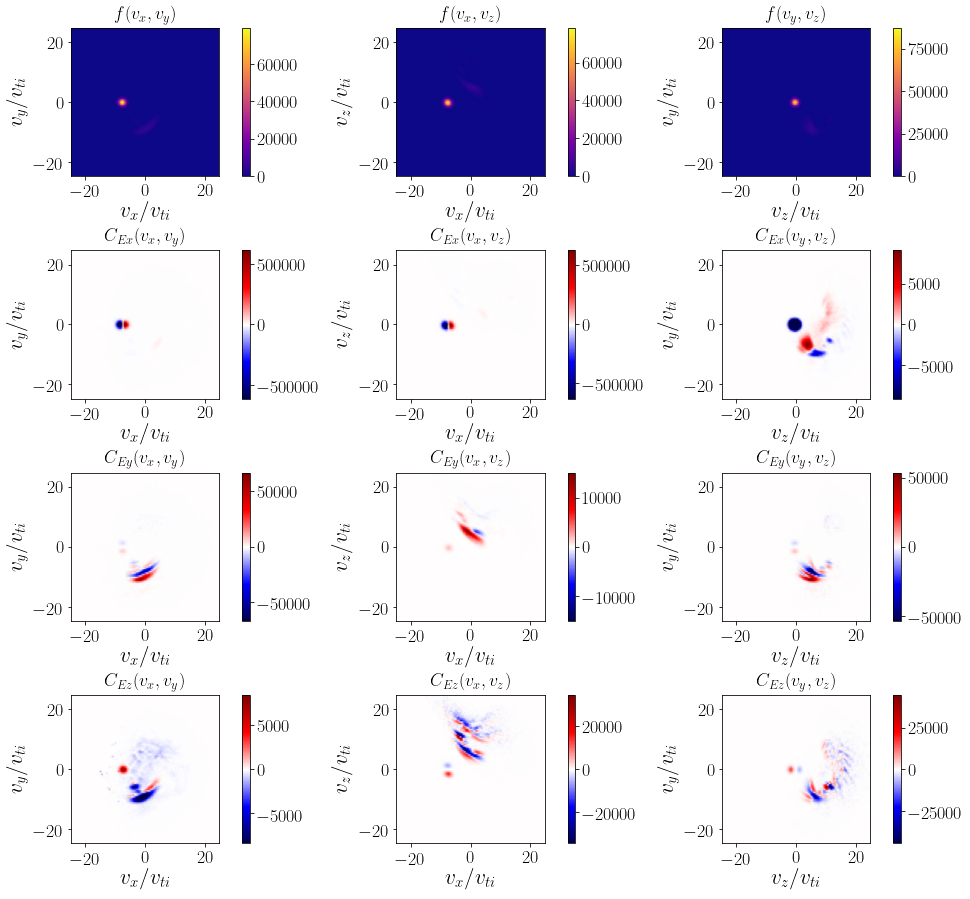

In [24]:
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

### Do correlation using subset of yz box extent

In [25]:
x1 = startval
x2 = endval
y1 = 0.
y2 = 3.
z1 = 0.
z2 = 3.

fieldkey = 'ex'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEx = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfluc, vshock, fieldkey, directionkey)

fieldkey = 'ey'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEy = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfluc, vshock, fieldkey, directionkey)

fieldkey = 'ez'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEz = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfluc, vshock, fieldkey, directionkey)

vx_xy,vy_xz = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
vx_xz,vz_xz = ao.mesh_3d_to_2d(vx,vy,vz,'xz')
vy_yz,vz_yz = ao.mesh_3d_to_2d(vx,vy,vz,'yz')
H_xy = ao.array_3d_to_2d(hist,'xy')
H_xz = ao.array_3d_to_2d(hist,'xz')
H_yz = ao.array_3d_to_2d(hist,'yz')
CEx_xy = ao.array_3d_to_2d(CEx,'xy')
CEx_xz = ao.array_3d_to_2d(CEx,'xz')
CEx_yz = ao.array_3d_to_2d(CEx,'yz')
CEy_xy = ao.array_3d_to_2d(CEy,'xy')
CEy_xz = ao.array_3d_to_2d(CEy,'xz')
CEy_yz = ao.array_3d_to_2d(CEy,'yz')
CEz_xy = ao.array_3d_to_2d(CEz,'xy')
CEz_xz = ao.array_3d_to_2d(CEz,'xz')
CEz_yz = ao.array_3d_to_2d(CEz,'yz')

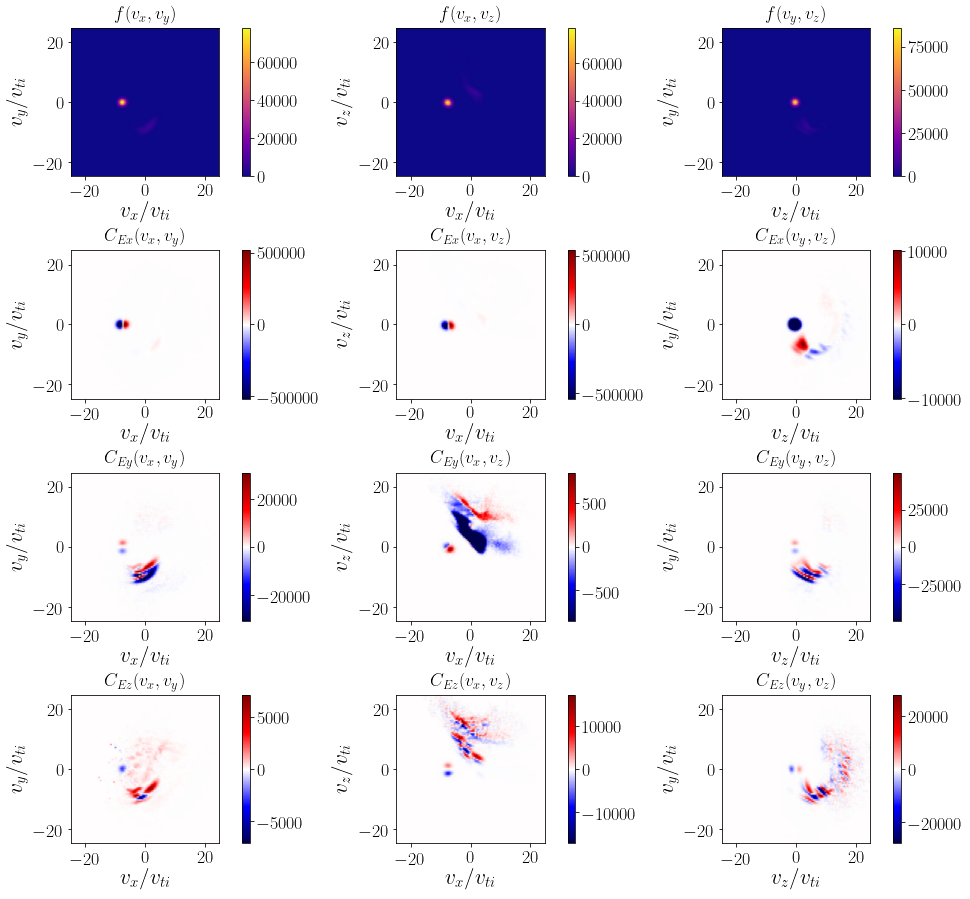

In [26]:
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)